In [1]:
import os
import time
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from skimage import color
!pip install torchinfo
from torchinfo import summary

In [2]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(150,150), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(150,150), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)

	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	1 x 1 x H_orig x W_orig
	# out_ab 		1 x 2 x H x W

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	# call resize function if needed
	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()
		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if pretrained:
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model

In [3]:
class ColorizationDataset(torch.utils.data.Dataset):
    '''Used to train the entire model'''
    def __init__(self, root_dir, transform=None, max_samples=100):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        img_lab = color.rgb2lab(img.numpy().transpose((1, 2, 0)))
        img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
        L = img_lab[..., :1]
        ab = img_lab[..., 1:]
        L = torch.from_numpy(L.transpose((2, 0, 1))).float()
        ab = torch.from_numpy(ab.transpose((2, 0, 1))).float()
        L = torch.nn.functional.pad(L, (1, 1, 1, 1), mode='constant', value=0)  # Padding (left, right, top, bottom)
        ab = torch.nn.functional.pad(ab, (1, 1, 1, 1), mode='constant', value=0)  # Padding (left, right, top, bottom)
        return L, ab

transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

train_dataset = ColorizationDataset(root_dir='drive/MyDrive/dataset/train', transform=transform)
val_dataset = ColorizationDataset(root_dir='drive/MyDrive/dataset/validation', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

print("Train Dataset Size:", len(train_dataset), "Train Loader Size:", len(train_loader))
print("Val Dataset Size:", len(val_dataset), "Val Loader Size:", len(val_loader))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

print("Dataset_sizes / Dataloaders")
print(dataset_sizes)
print(dataloaders)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    # Lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0

            if phase == 'train':
                model.train()
            else:
                model.eval()

            with tqdm(total=len(dataloaders[phase]), desc=f'{phase} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets) # Compute loss

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)

                    # Progress bar
                    pbar.set_postfix({'Loss': loss.item()})
                    pbar.update(1)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                else:
                    val_losses.append(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f}')

                # Deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')

            epoch_duration = time.time() - epoch_start_time
            print(f'Epoch {epoch+1} completed in {epoch_duration:.2f} seconds')
            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

Train Dataset Size: 4277 Train Loader Size: 1070
Val Dataset Size: 1436 Val Loader Size: 359
Dataset_sizes / Dataloaders
{'train': 4277, 'val': 1436}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7dffb820a950>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7dffb820b340>}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/25
----------


train Epoch 1/25: 100%|██████████| 1070/1070 [04:00<00:00,  4.45batch/s, Loss=0.00433]


train Loss: 0.0067
Epoch 1 completed in 240.63 seconds



val Epoch 1/25: 100%|█████████▉| 358/359 [02:27<00:00,  2.13batch/s, Loss=0.00625]

val Loss: 0.0064


val Epoch 1/25: 100%|██████████| 359/359 [02:28<00:00,  2.42batch/s, Loss=0.00625]


Epoch 1 completed in 388.88 seconds

Epoch 2/25
----------


train Epoch 2/25: 100%|██████████| 1070/1070 [02:15<00:00,  7.92batch/s, Loss=0.00622]


train Loss: 0.0060
Epoch 2 completed in 135.04 seconds



val Epoch 2/25: 100%|██████████| 359/359 [00:16<00:00, 21.70batch/s, Loss=0.00809]


val Loss: 0.0083
Epoch 2 completed in 151.60 seconds

Epoch 3/25
----------


train Epoch 3/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.0148]


train Loss: 0.0061
Epoch 3 completed in 134.22 seconds



val Epoch 3/25: 100%|█████████▉| 358/359 [00:16<00:00, 25.56batch/s, Loss=0.00564]

val Loss: 0.0062


val Epoch 3/25: 100%|██████████| 359/359 [00:16<00:00, 21.71batch/s, Loss=0.00564]


Epoch 3 completed in 150.76 seconds

Epoch 4/25
----------


train Epoch 4/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.01batch/s, Loss=0.00553]


train Loss: 0.0058
Epoch 4 completed in 133.59 seconds



val Epoch 4/25: 100%|██████████| 359/359 [00:16<00:00, 22.24batch/s, Loss=0.0101]


val Loss: 0.0086
Epoch 4 completed in 149.74 seconds

Epoch 5/25
----------


train Epoch 5/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.02batch/s, Loss=0.0043]


train Loss: 0.0058
Epoch 5 completed in 133.35 seconds



val Epoch 5/25: 100%|█████████▉| 358/359 [00:16<00:00, 23.25batch/s, Loss=0.00585]

val Loss: 0.0056


val Epoch 5/25: 100%|██████████| 359/359 [00:16<00:00, 21.83batch/s, Loss=0.00585]


Epoch 5 completed in 149.81 seconds

Epoch 6/25
----------


train Epoch 6/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.02batch/s, Loss=0.00393]


train Loss: 0.0057
Epoch 6 completed in 133.34 seconds



val Epoch 6/25: 100%|██████████| 359/359 [00:16<00:00, 21.67batch/s, Loss=0.00723]


val Loss: 0.0062
Epoch 6 completed in 149.92 seconds

Epoch 7/25
----------


train Epoch 7/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.00batch/s, Loss=0.00978]


train Loss: 0.0056
Epoch 7 completed in 133.68 seconds



val Epoch 7/25: 100%|██████████| 359/359 [00:16<00:00, 21.40batch/s, Loss=0.00568]


val Loss: 0.0062
Epoch 7 completed in 150.46 seconds

Epoch 8/25
----------


train Epoch 8/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.95batch/s, Loss=0.00347]


train Loss: 0.0056
Epoch 8 completed in 134.55 seconds



val Epoch 8/25: 100%|██████████| 359/359 [00:16<00:00, 21.29batch/s, Loss=0.007]


val Loss: 0.0064
Epoch 8 completed in 151.42 seconds

Epoch 9/25
----------


train Epoch 9/25: 100%|██████████| 1070/1070 [02:13<00:00,  7.99batch/s, Loss=0.00611]


train Loss: 0.0055
Epoch 9 completed in 133.90 seconds



val Epoch 9/25: 100%|██████████| 359/359 [00:16<00:00, 21.50batch/s, Loss=0.00475]


val Loss: 0.0060
Epoch 9 completed in 150.61 seconds

Epoch 10/25
----------


train Epoch 10/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.00batch/s, Loss=0.00505]


train Loss: 0.0054
Epoch 10 completed in 133.79 seconds



val Epoch 10/25: 100%|██████████| 359/359 [00:16<00:00, 21.47batch/s, Loss=0.00381]


val Loss: 0.0068
Epoch 10 completed in 150.52 seconds

Epoch 11/25
----------


train Epoch 11/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.01batch/s, Loss=0.0036]


train Loss: 0.0054
Epoch 11 completed in 133.53 seconds



val Epoch 11/25: 100%|██████████| 359/359 [00:16<00:00, 22.01batch/s, Loss=0.0115]


val Loss: 0.0082
Epoch 11 completed in 149.84 seconds

Epoch 12/25
----------


train Epoch 12/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.00402]


train Loss: 0.0053
Epoch 12 completed in 134.22 seconds



val Epoch 12/25: 100%|██████████| 359/359 [00:16<00:00, 21.93batch/s, Loss=0.00736]


val Loss: 0.0057
Epoch 12 completed in 150.60 seconds

Epoch 13/25
----------


train Epoch 13/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.98batch/s, Loss=0.00299]


train Loss: 0.0053
Epoch 13 completed in 134.11 seconds



val Epoch 13/25: 100%|██████████| 359/359 [00:16<00:00, 21.38batch/s, Loss=0.00512]


val Loss: 0.0060
Epoch 13 completed in 150.91 seconds

Epoch 14/25
----------


train Epoch 14/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.00batch/s, Loss=0.00461]


train Loss: 0.0052
Epoch 14 completed in 133.77 seconds



val Epoch 14/25: 100%|██████████| 359/359 [00:16<00:00, 21.13batch/s, Loss=0.00898]


val Loss: 0.0063
Epoch 14 completed in 150.77 seconds

Epoch 15/25
----------


train Epoch 15/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.00686]


train Loss: 0.0052
Epoch 15 completed in 134.34 seconds



val Epoch 15/25: 100%|██████████| 359/359 [00:16<00:00, 21.54batch/s, Loss=0.0117]


val Loss: 0.0078
Epoch 15 completed in 151.01 seconds

Epoch 16/25
----------


train Epoch 16/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.94batch/s, Loss=0.00336]


train Loss: 0.0051
Epoch 16 completed in 134.74 seconds



val Epoch 16/25: 100%|██████████| 359/359 [00:17<00:00, 20.57batch/s, Loss=0.00465]


val Loss: 0.0069
Epoch 16 completed in 152.21 seconds

Epoch 17/25
----------


train Epoch 17/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.00441]


train Loss: 0.0050
Epoch 17 completed in 134.20 seconds



val Epoch 17/25: 100%|██████████| 359/359 [00:16<00:00, 21.23batch/s, Loss=0.00594]


val Loss: 0.0091
Epoch 17 completed in 151.12 seconds

Epoch 18/25
----------


train Epoch 18/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.98batch/s, Loss=0.00329]


train Loss: 0.0049
Epoch 18 completed in 134.16 seconds



val Epoch 18/25: 100%|██████████| 359/359 [00:16<00:00, 21.70batch/s, Loss=0.00556]


val Loss: 0.0060
Epoch 18 completed in 150.72 seconds

Epoch 19/25
----------


train Epoch 19/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.98batch/s, Loss=0.00697]


train Loss: 0.0049
Epoch 19 completed in 134.07 seconds



val Epoch 19/25: 100%|█████████▉| 358/359 [00:16<00:00, 25.19batch/s, Loss=0.00534]

val Loss: 0.0051


val Epoch 19/25: 100%|██████████| 359/359 [00:16<00:00, 21.20batch/s, Loss=0.00534]


Epoch 19 completed in 151.01 seconds

Epoch 20/25
----------


train Epoch 20/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.95batch/s, Loss=0.00347]


train Loss: 0.0048
Epoch 20 completed in 134.52 seconds



val Epoch 20/25: 100%|██████████| 359/359 [00:16<00:00, 21.58batch/s, Loss=0.00594]


val Loss: 0.0055
Epoch 20 completed in 151.17 seconds

Epoch 21/25
----------


train Epoch 21/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.00331]


train Loss: 0.0048
Epoch 21 completed in 134.28 seconds



val Epoch 21/25: 100%|█████████▉| 358/359 [00:16<00:00, 20.57batch/s, Loss=0.00597]

val Loss: 0.0048


val Epoch 21/25: 100%|██████████| 359/359 [00:17<00:00, 20.70batch/s, Loss=0.00597]


Epoch 21 completed in 151.63 seconds

Epoch 22/25
----------


train Epoch 22/25: 100%|██████████| 1070/1070 [02:14<00:00,  7.97batch/s, Loss=0.00365]


train Loss: 0.0047
Epoch 22 completed in 134.18 seconds



val Epoch 22/25: 100%|██████████| 359/359 [00:16<00:00, 21.46batch/s, Loss=0.00404]


val Loss: 0.0052
Epoch 22 completed in 150.92 seconds

Epoch 23/25
----------


train Epoch 23/25: 100%|██████████| 1070/1070 [02:13<00:00,  8.00batch/s, Loss=0.00441]


train Loss: 0.0046
Epoch 23 completed in 133.72 seconds



val Epoch 23/25: 100%|██████████| 359/359 [00:16<00:00, 21.68batch/s, Loss=0.00456]


val Loss: 0.0048
Epoch 23 completed in 150.29 seconds

Epoch 24/25
----------


train Epoch 24/25: 100%|██████████| 1070/1070 [02:13<00:00,  7.99batch/s, Loss=0.0107]


train Loss: 0.0046
Epoch 24 completed in 134.00 seconds



val Epoch 24/25: 100%|██████████| 359/359 [00:16<00:00, 25.29batch/s, Loss=0.00437]

val Loss: 0.0048


val Epoch 24/25: 100%|██████████| 359/359 [00:17<00:00, 21.11batch/s, Loss=0.00437]


Epoch 24 completed in 151.01 seconds

Epoch 25/25
----------


train Epoch 25/25: 100%|██████████| 1070/1070 [02:13<00:00,  7.99batch/s, Loss=0.00453]


train Loss: 0.0046
Epoch 25 completed in 133.97 seconds



val Epoch 25/25: 100%|█████████▉| 358/359 [00:16<00:00, 23.06batch/s, Loss=0.00433]

val Loss: 0.0048


val Epoch 25/25: 100%|██████████| 359/359 [00:17<00:00, 20.71batch/s, Loss=0.00433]


Epoch 25 completed in 151.32 seconds

Training complete in 66m 48s
Best val loss: 0.0048


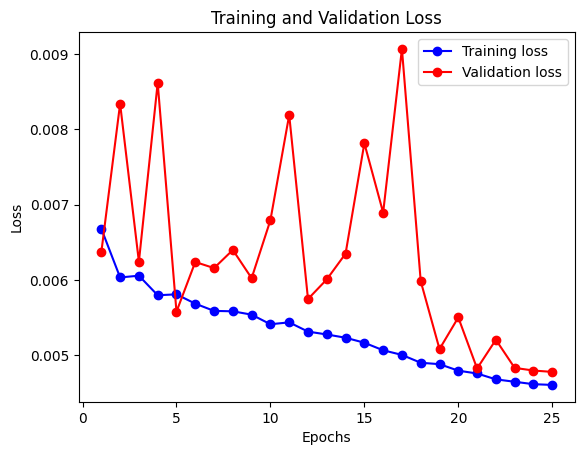

In [4]:
if __name__ == '__main__':
    model = eccv16(pretrained=False)
    model = model.to(device)

    summary(model, input_size=(4, 1, 150, 150))

    num_epochs = 25
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    model, train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, num_epochs)

    # Plot the loss curves
    epochs = range(1, num_epochs+1)
    plt.figure()
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Test Dataset Size: 1426 Test Loader Size: 357


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-7-029d3ddfe617>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary o

Test Loss: 0.0051


<ipython-input-7-029d3ddfe617>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img_lab)
<ipython-input-7-029d3ddfe617>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 57 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img_lab)
<ipython-input-7-029d3ddfe617>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img_lab)
<ipython-input-7-029d3ddfe617>:54: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 64 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img_lab)


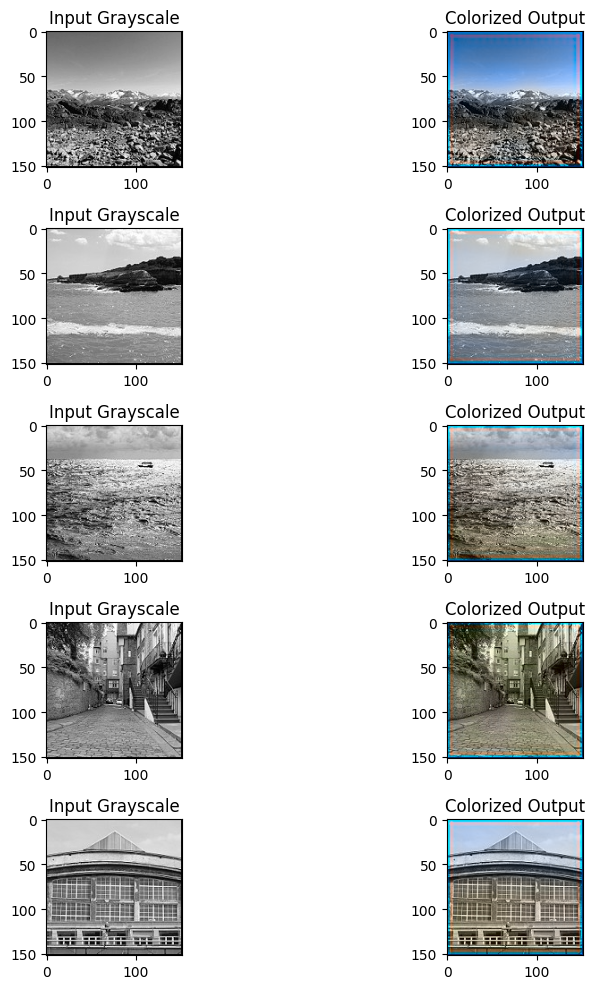

In [7]:
def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    # Calculate average test loss
    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    return test_loss

# Load best model weights
test_dataset = ColorizationDataset(root_dir='drive/MyDrive/dataset/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)
print("Test Dataset Size:", len(test_dataset), "Test Loader Size:", len(test_loader))
model.load_state_dict(torch.load('best_model.pth'))

# Run the test model
test_loss = test_model(model, criterion, test_loader)

# Visualize a few test results
def visualize_colorization(model, test_loader, num_images=5):
    model.eval()  # Set to evaluation mode
    plt.figure(figsize=(10, 10))
    for i, (inputs, targets) in enumerate(test_loader):
        if i >= num_images:
            break
        inputs = inputs.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)

        # Move data back to CPU for plotting
        inputs = inputs.cpu()
        outputs = outputs.cpu()

        # Convert from L and ab channels to RGB
        for j in range(inputs.size(0)):
            img_L = inputs[j].cpu().numpy().squeeze() * 100  # Scale L channel to [0, 100]
            # Adjust ab channels to [-128, 127] range
            img_ab = outputs[j].cpu().numpy().transpose((1, 2, 0)) * 255 - 128
            img_lab = np.concatenate([img_L[:, :, np.newaxis], img_ab], axis=2)
            img_rgb = color.lab2rgb(img_lab)
            img_rgb = img_rgb[1:-1, 1:-1, :] # Crop to 150 x 150

            # Display the grayscale input and colorized output
            plt.subplot(num_images, 2, 2 * i + 1)
            plt.imshow(img_L, cmap='gray')
            plt.title('Input Grayscale')

            plt.subplot(num_images, 2, 2 * i + 2)
            plt.imshow(img_rgb)
            plt.title('Colorized Output')

    plt.tight_layout()
    plt.show()

# Visualize colorization results
visualize_colorization(model, test_loader, num_images=5)